In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()


,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,81680.0,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,81723.0,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,81772.0,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,81831.0,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,81878.0,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [3]:
pd.date_range(start = '2017-11-09', end = '2022-02-04' ).difference(df.index)


DatetimeIndex(['2021-04-16', '2021-05-05', '2021-05-09'], dtype='datetime64[ns]', freq=None)

In [4]:

df = df.resample('D').ffill()

In [5]:
pd.date_range(start = '2017-11-09', end = '2022-02-04' ).difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

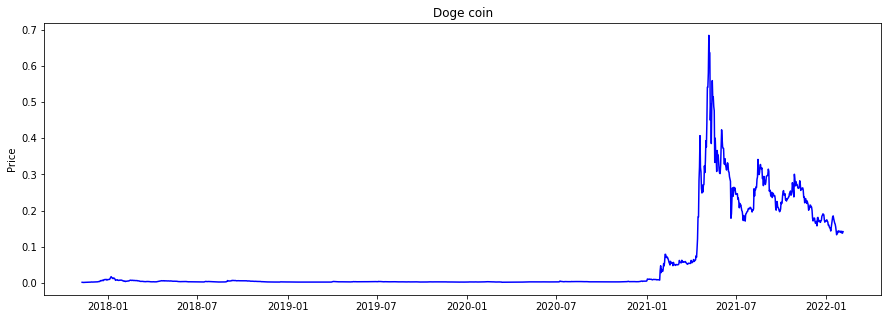

In [6]:
plt.figure(figsize=(15,5))
plt.ylabel('Price')
plt.title('Doge coin')
plt.plot(df['Close'],'b-');



In [7]:
#ADF pokazuje da nisu stacionarni podaci
X = df['Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.989048
p-value: 0.291396
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [8]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
kpss_test(df['Close'].values)


Results of KPSS Test:
Test Statistic            2.903298
p-value                   0.010000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


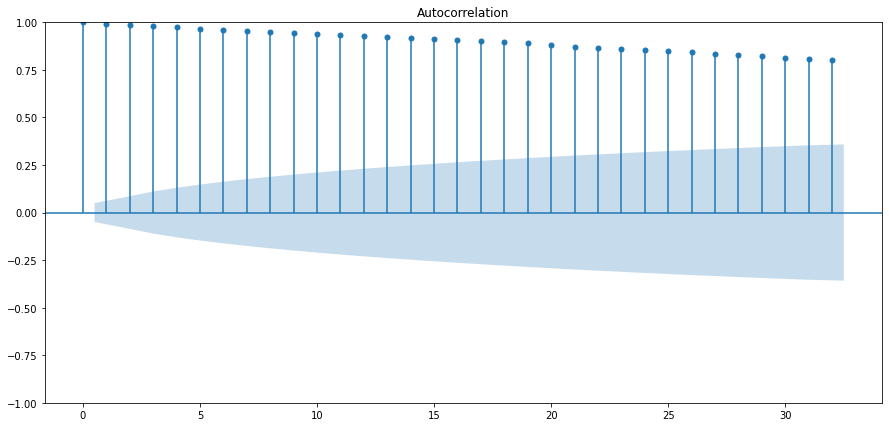

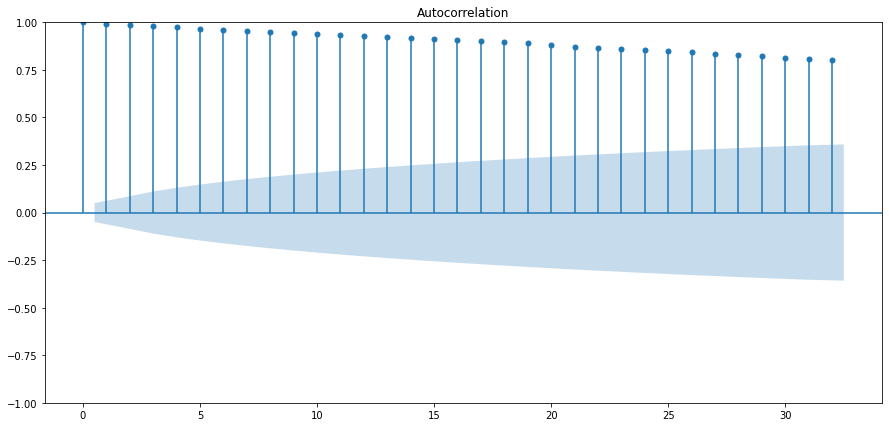

In [9]:
# Original Series
plot_acf(df.Close)

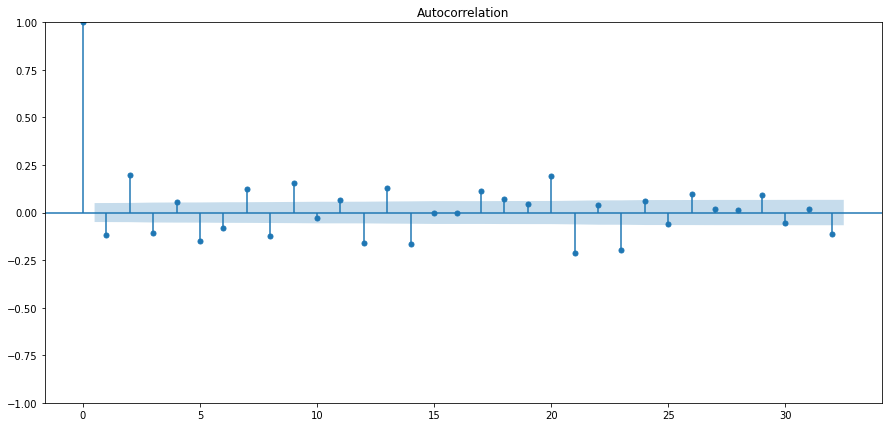

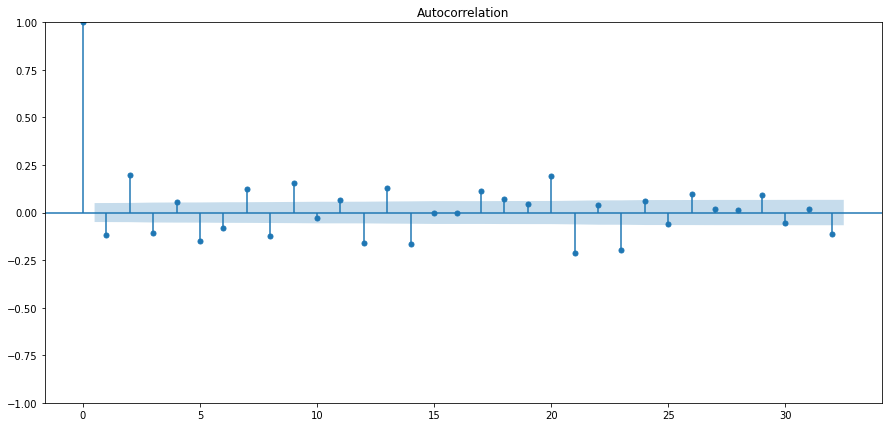

In [10]:
# 1st Differencing
plot_acf(df.Close.diff().dropna())

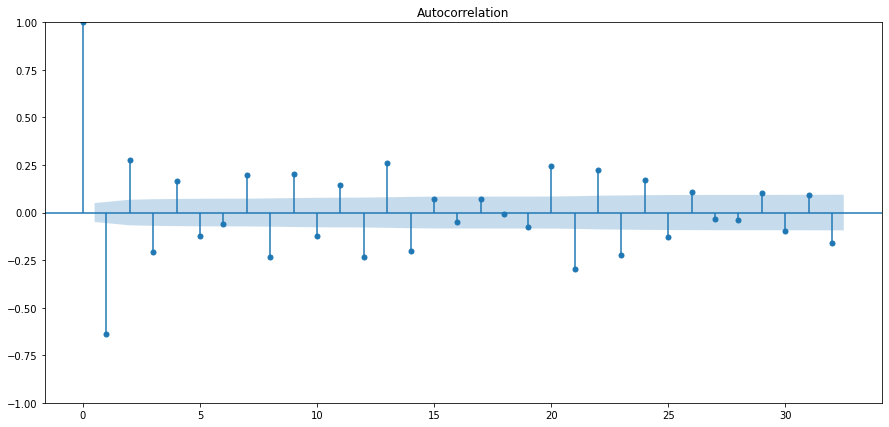

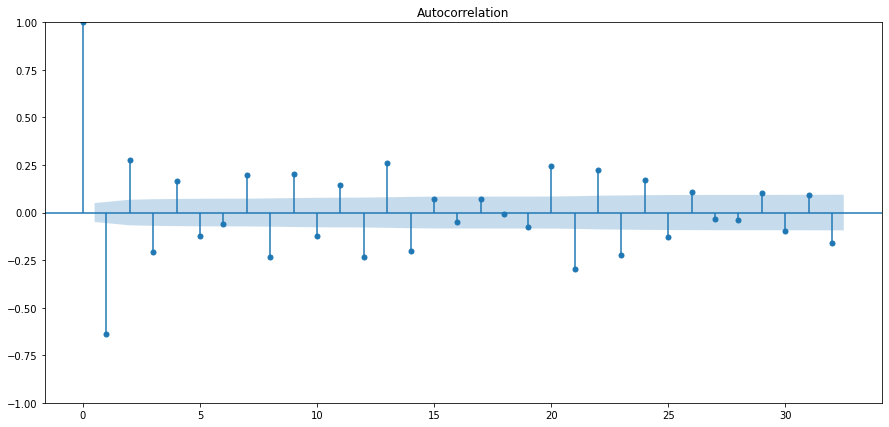

In [11]:
# 2nd Differencing
plot_acf(df.Close.diff().diff().dropna())



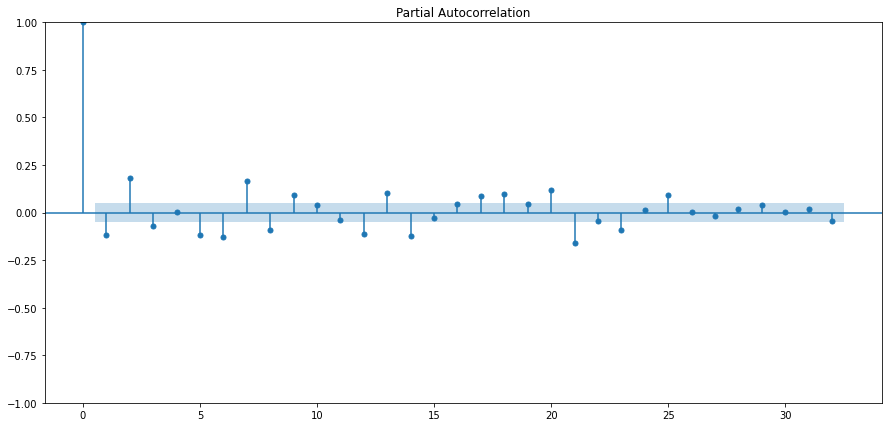

In [12]:
#Ispada da je stacionarniji da kecu nego na dvojci
plot = plot_pacf(df.Close.diff().dropna())
plot.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


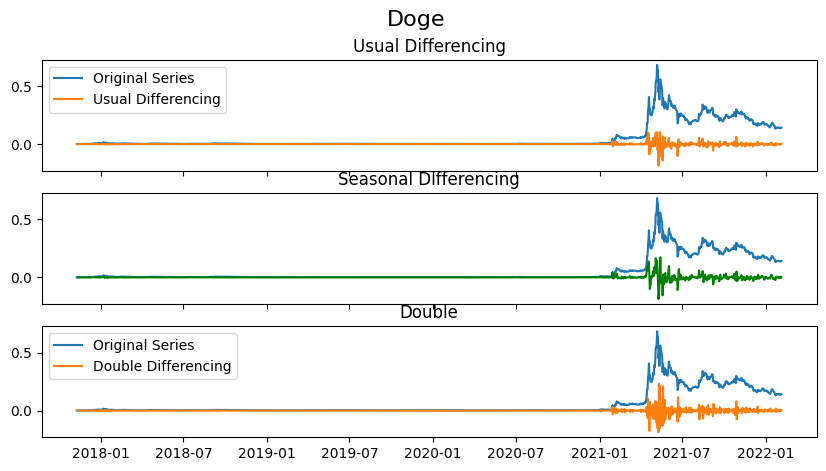

In [13]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df.Close, label='Original Series')
axes[0].plot(df.Close.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df.Close, label='Original Series')
axes[1].plot(df.Close.diff(2), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Doge', fontsize=16)

# double diff
axes[2].plot(df.Close, label='Original Series')
axes[2].plot(df.Close.diff(1).diff(1), label='Double Differencing')
axes[2].set_title('Double')
axes[2].legend(loc='upper left', fontsize=10)
plt.show()


<Figure size 1080x504 with 0 Axes>

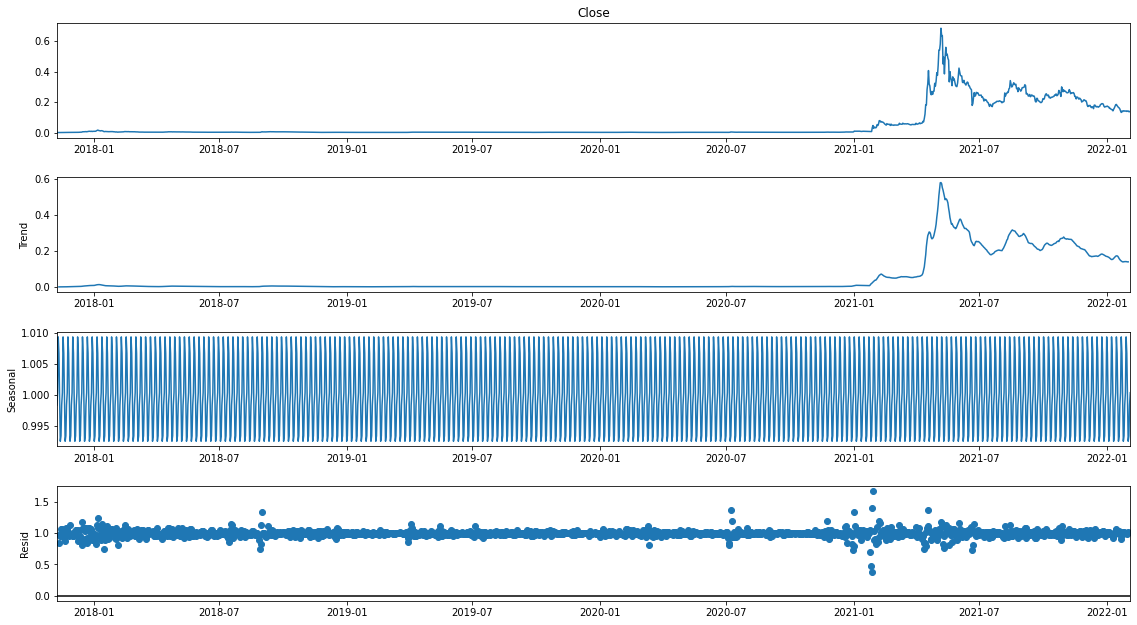

In [14]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df.Close, model='multiplicative')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


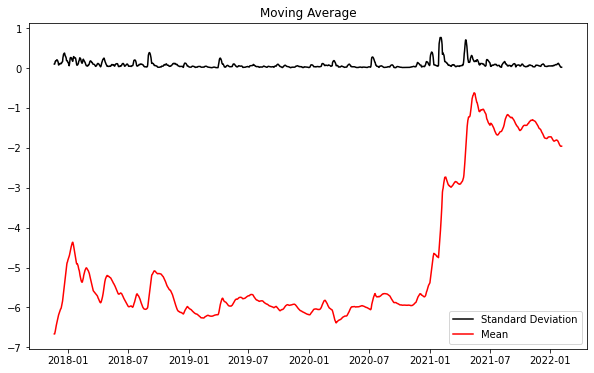

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

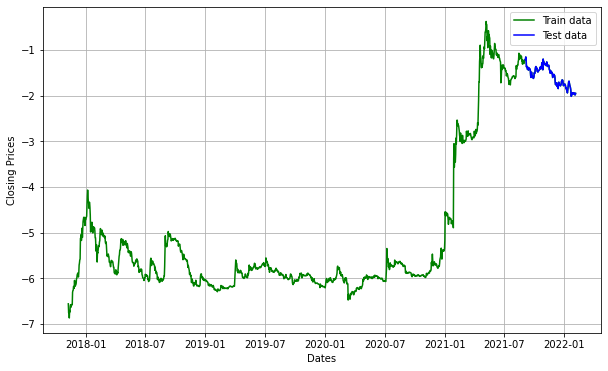

In [16]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2953.432, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2953.869, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2952.977, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2953.046, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2952.575, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.089 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1391
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1478.934
Date:                Wed, 16 Feb 2022   AIC                          -2953.869
Time:                        16:44:30   BIC                          -2943.394
Sample:                             0   HQIC                         -2949.952
                               - 1391                                  

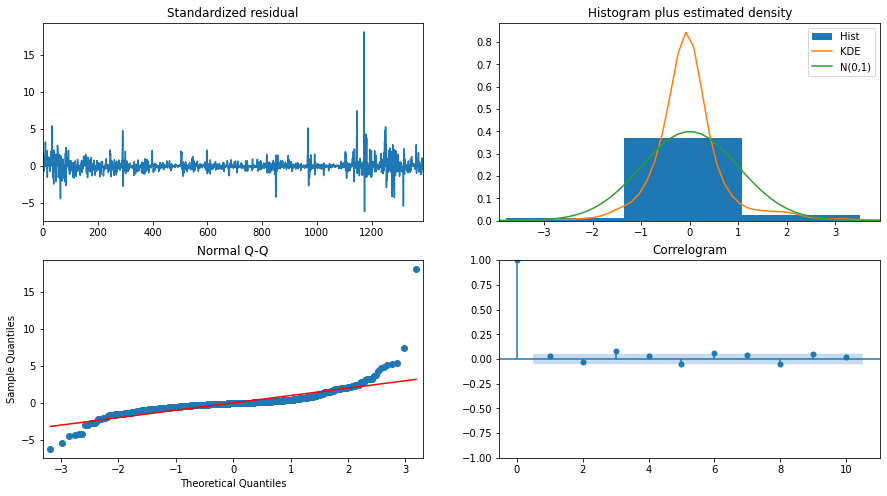

In [17]:
from pmdarima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
from statsmodels.tsa.arima.model import ARIMA

#Modeling
# Build Model
model = ARIMA(train_data, order=(4,1,4))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1391
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1491.714
Date:                Wed, 16 Feb 2022   AIC                          -2965.429
Time:                        16:44:38   BIC                          -2918.295
Sample:                    11-12-2017   HQIC                         -2947.803
                         - 09-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4475      0.590     -0.759      0.448      -1.603       0.708
ar.L2         -0.0072      0.141     -0.051      0.959      -0.284       0.270
ar.L3          0.7583      0.106      7.139      0.0

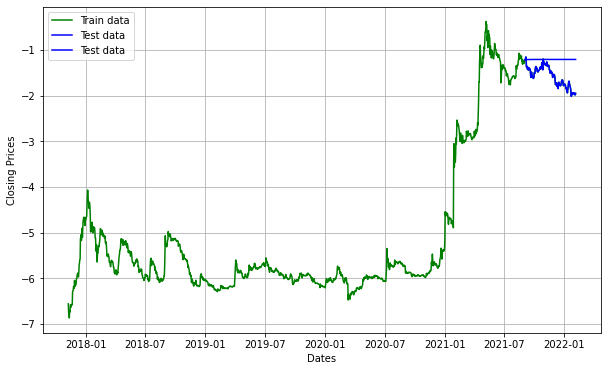

In [19]:
res = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_series = pd.Series(res, index=test_data.index)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(fc_series, 'blue', label='Test data')
plt.legend()

Process finished!
Process finished!
Process finished!
Process finished!
Process finished!


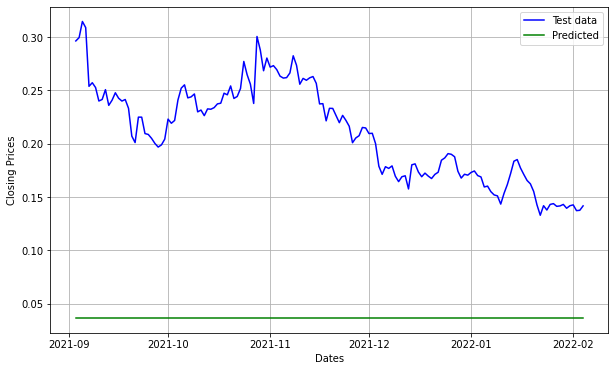

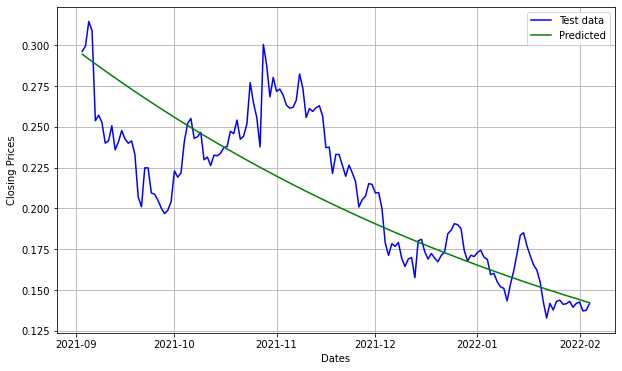

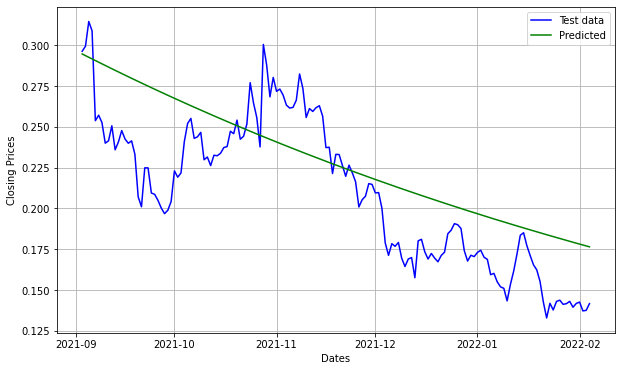

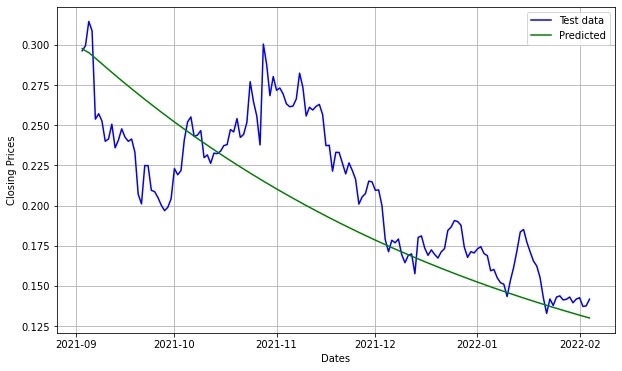

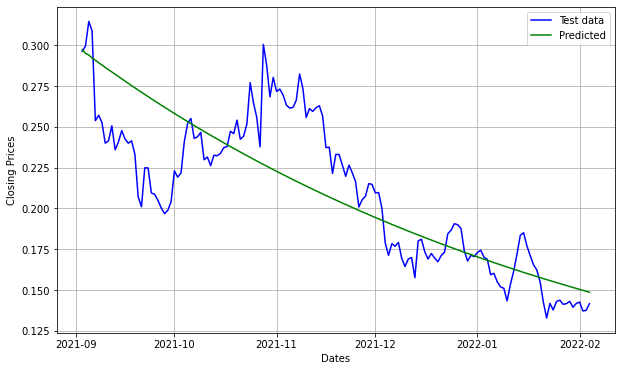

In [21]:
from python_scripts.sarima_helper import try_different_model_combinations

#Ajmo onda automatski tester da probamo
df = pd.read_csv('../doge_v1.csv', index_col='Date', parse_dates=True)
df = df.resample('D').ffill()
df_basic_info = df[['Open','High','Low','Close']]
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]
try_different_model_combinations(train, test, 'Close')

Process finished!
Process finished!
Process finished!
Process finished!
Process finished!


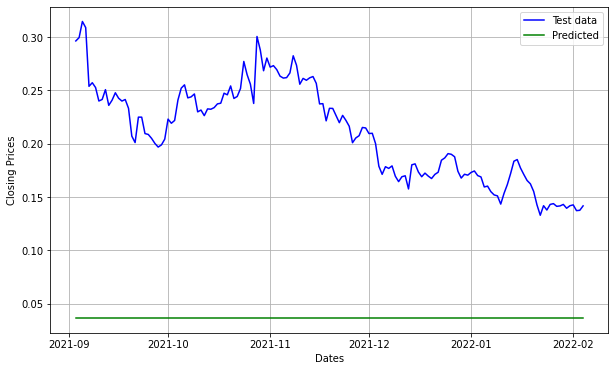

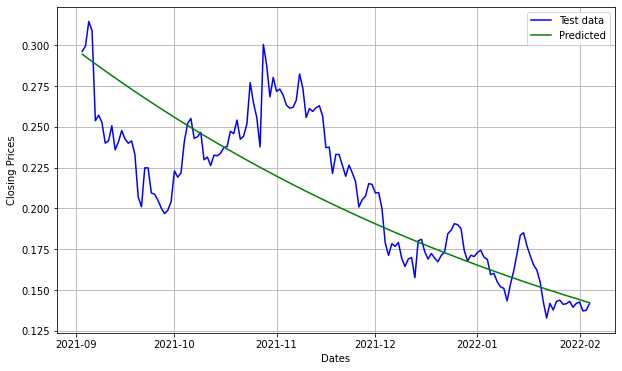

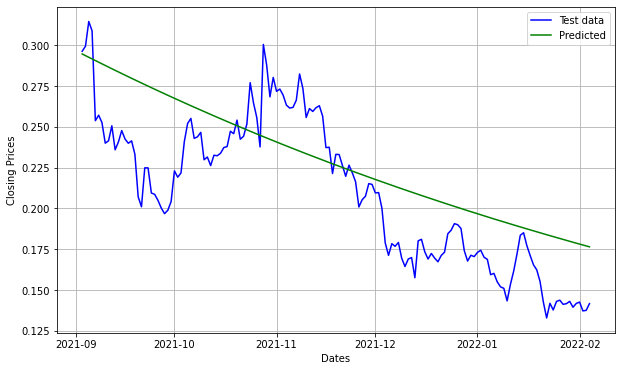

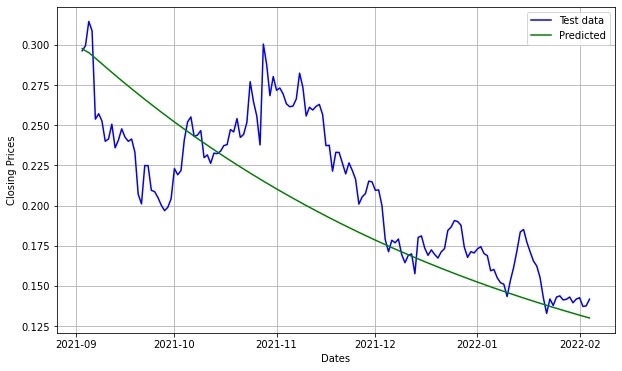

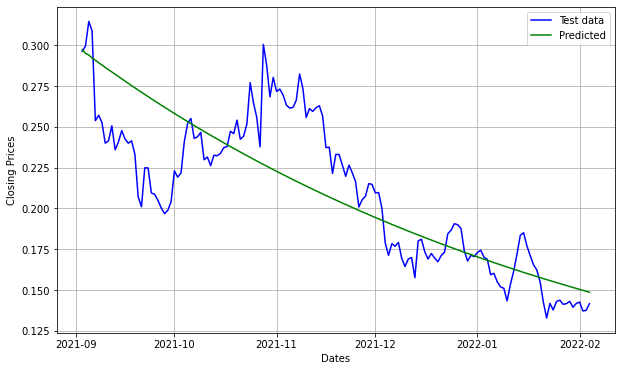

In [22]:
testNum = round(df_basic_info.shape[0] * 0.1)
train = df_basic_info.iloc[:-testNum]
test = df_basic_info.iloc[-testNum:]
try_different_model_combinations(train, test, 'Close')

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9296.720, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9293.111, Time=5.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9310.444, Time=7.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9297.732, Time=3.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9311.817, Time=1.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9309.037, Time=7.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9314.252, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9298.645, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9278.535, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-9304.855, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-9306.421, Time=0.98 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9250.893, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-9299.661, Time=2.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-9313.707, Time=1.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-9310.089, Time=1.64

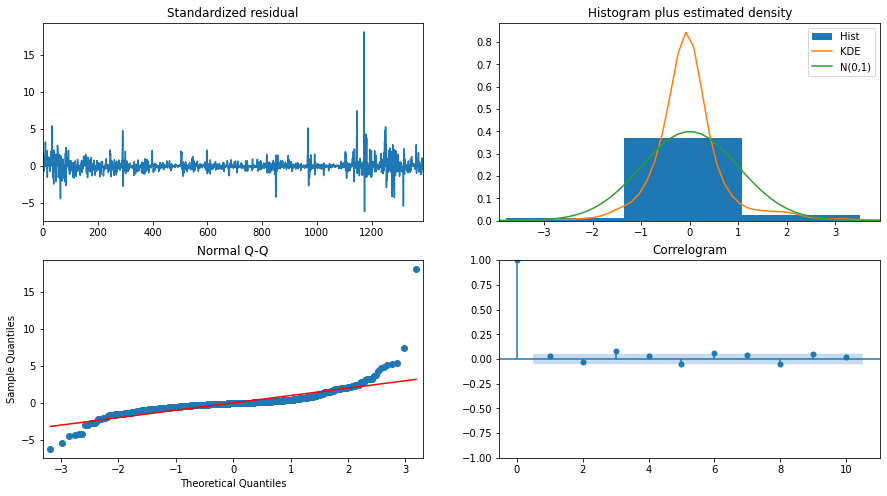

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9302.946, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9234.812, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9254.918, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9248.995, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9236.727, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9312.408, Time=3.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9296.720, Time=1.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9293.111, Time=5.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9310.444, Time=6.92 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9297.732, Time=3.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9311.817, Time=1.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9309.037, Time=7.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9314.252, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9298.645, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0

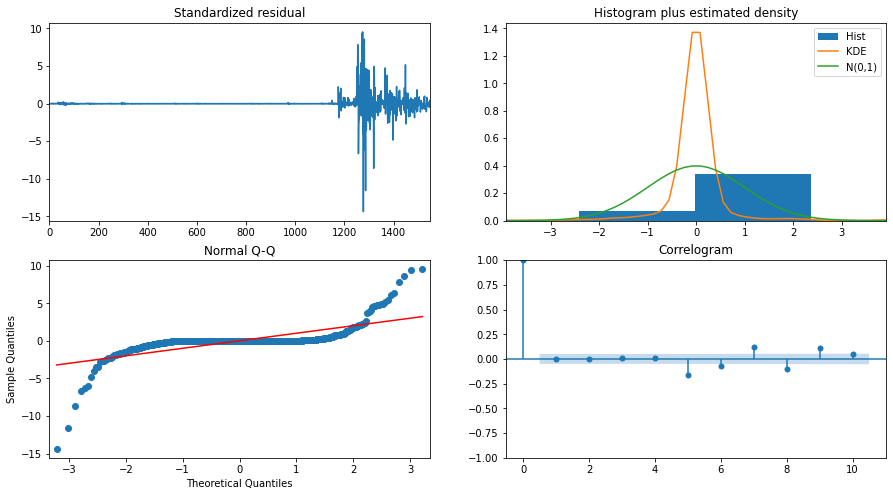